In [23]:
import numpy as np
from ultralytics import YOLO
import os
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
models = [
    YOLO('runs/detect/train13 (best)/weights/best.pt'),
    YOLO('runs/detect/train16/weights/best.pt')
]

val_img_dir = "Data/images/val"
val_lbl_dir = "Data/labels/val"

image_extensions = ['*.jpg', '*.jpeg', '*.png']
image_paths = []
for ext in image_extensions:
    image_paths.extend(glob(os.path.join(val_img_dir, ext)))
image_paths = sorted(image_paths)

In [ ]:
def compute_iou(box1, box2):
    """Each box is [x1, y1, x2, y2]"""
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2_area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

all_tp, all_fp, all_scores, all_gt_classes = [], [], [], []
iou_threshold = 0.5

def extract_boxes(result):
    if not result or not result[0].boxes:
        return np.empty((0, 6))
    b = result[0].boxes
    xyxy = b.xyxy.cpu().numpy()
    conf = b.conf.cpu().numpy()
    cls = b.cls.cpu().numpy()
    return np.column_stack((xyxy, conf, cls))


In [ ]:
for img_path in image_paths:
    filename = os.path.basename(img_path)
    label_path = os.path.join(val_lbl_dir, os.path.splitext(filename)[0] + '.txt')
    if not os.path.exists(label_path):
        continue

    gt_boxes = np.loadtxt(label_path).reshape(-1, 5)
    if len(gt_boxes) == 0:
        continue

    img = Image.open(img_path)
    w, h = img.size

    gt_converted = []
    for cls, cx, cy, bw, bh in gt_boxes:
        x1 = (cx - bw / 2) * w
        y1 = (cy - bh / 2) * h
        x2 = (cx + bw / 2) * w
        y2 = (cy + bh / 2) * h
        gt_converted.append([x1, y1, x2, y2, int(cls)])

    all_preds = [extract_boxes(m.predict(img_path, verbose=False)) for m in models]
    min_len = min(map(len, all_preds))
    if min_len == 0:
        continue

    combined_preds = []
    for i in range(min_len):
        boxes = [all_preds[j][i][:4] for j in range(len(models))]
        scores = [all_preds[j][i][4] for j in range(len(models))]
        classes = [all_preds[j][i][5] for j in range(len(models))]
        avg_box = np.mean(boxes, axis=0)
        avg_score = np.mean(scores)
        majority_class = int(np.round(np.mean(classes)))
        combined_preds.append([*avg_box, avg_score, majority_class])

    matched_gt = set()
    for pred in combined_preds:
        pred_box, pred_score, pred_cls = pred[:4], pred[4], int(pred[5])
        best_iou, best_gt_idx = 0, -1
        for idx, gt in enumerate(gt_converted):
            if idx in matched_gt: continue
            iou = compute_iou(pred_box, gt[:4])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        if best_iou >= iou_threshold and pred_cls == gt_converted[best_gt_idx][4]:
            all_tp.append(1)
            all_fp.append(0)
            matched_gt.add(best_gt_idx)
        else:
            all_tp.append(0)
            all_fp.append(1)
        all_scores.append(pred_score)
        all_gt_classes.append(pred_cls)

C:\Users\HP5CD\AppData\Local\Temp\ipykernel_14516\3191707493.py:7: UserWarning: loadtxt: input contained no data: "Data/labels/val\-101.80279212927333,-100.43091128943604,-89.99999999999996,-88.62811916016261.txt"
  gt_boxes = np.loadtxt(label_path).reshape(-1, 5)  # class x_center y_center width height
C:\Users\HP5CD\AppData\Local\Temp\ipykernel_14516\3191707493.py:7: UserWarning: loadtxt: input contained no data: "Data/labels/val\-123.75288556667027,-122.38100472683296,-89.99999999999996,-88.62811916016261.txt"
  gt_boxes = np.loadtxt(label_path).reshape(-1, 5)  # class x_center y_center width height
C:\Users\HP5CD\AppData\Local\Temp\ipykernel_14516\3191707493.py:7: UserWarning: loadtxt: input contained no data: "Data/labels/val\-125.12476640650756,-123.75288556667027,-89.99999999999996,-88.62811916016261.txt"
  gt_boxes = np.loadtxt(label_path).reshape(-1, 5)  # class x_center y_center width height
C:\Users\HP5CD\AppData\Local\Temp\ipykernel_14516\3191707493.py:7: UserWarning: loadt

Average Precision: 0.1238


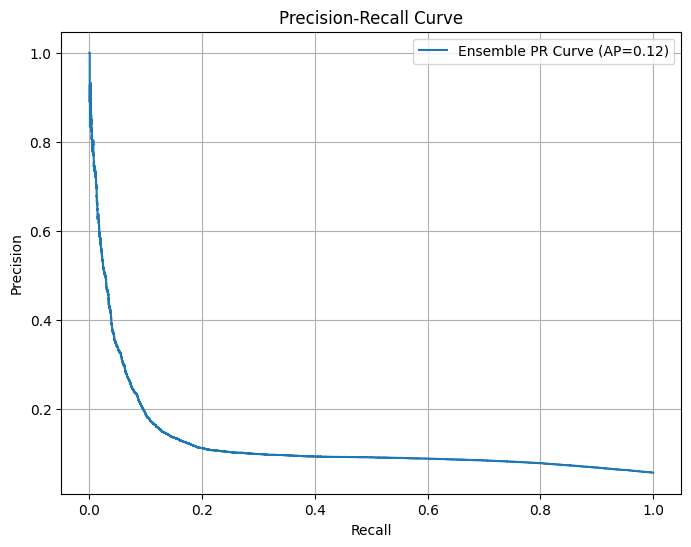

In [ ]:
precision, recall, _ = precision_recall_curve(all_tp, all_scores)
ap = average_precision_score(all_tp, all_scores)

print(f"Average Precision: {ap:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Ensemble PR Curve (AP={ap:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.legend()
plt.show()

In [ ]:
import seaborn as sns

def compute_detection_confusion_matrix(gt_classes, pred_classes, num_classes, class_names=None):
    """
    Compute and plot a confusion matrix for object detection.

    Args:
        gt_classes: list of ground truth class IDs (including FN as actual class, with pred = background)
        pred_classes: list of predicted class IDs (including FP as predicted class, with gt = background)
        num_classes: number of object classes
        class_names: list of class names (optional)
    """
    bg = num_classes
    labels = list(range(num_classes)) + [bg]

    cm = confusion_matrix(gt_classes, pred_classes, labels=labels)

    if class_names:
        display_labels = class_names + ['background']
    else:
        display_labels = [str(i) for i in range(num_classes)] + ['background']

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=display_labels, yticklabels=display_labels, cmap='Blues')
    plt.xlabel('Predicted Class')
    plt.ylabel('Ground Truth Class')
    plt.title('Detection Confusion Matrix')
    plt.show()

    return cm


In [ ]:
iou_threshold = 0.5
category_names = ['crater']
num_classes = len(category_names)
bg_class = num_classes

gt_classes_for_cm = []
pred_classes_for_cm = []

In [ ]:
for img_path in image_paths:
    filename = os.path.basename(img_path)
    label_path = os.path.join(val_lbl_dir, os.path.splitext(filename)[0] + '.txt')
    if not os.path.exists(label_path):
        continue

    gt_boxes = np.loadtxt(label_path).reshape(-1, 5)
    if len(gt_boxes) == 0:
        continue

    img = Image.open(img_path)
    w, h = img.size

    gt_converted = []
    for cls, cx, cy, bw, bh in gt_boxes:
        x1 = (cx - bw / 2) * w
        y1 = (cy - bh / 2) * h
        x2 = (cx + bw / 2) * w
        y2 = (cy + bh / 2) * h
        gt_converted.append([x1, y1, x2, y2, int(cls)])

    all_preds = [extract_boxes(m.predict(img_path, verbose=False)) for m in models]
    min_len = min(map(len, all_preds))
    if min_len == 0:
        continue

    combined_preds = []
    for i in range(min_len):
        boxes = [all_preds[j][i][:4] for j in range(len(models))]
        scores = [all_preds[j][i][4] for j in range(len(models))]
        classes = [all_preds[j][i][5] for j in range(len(models))]
        avg_box = np.mean(boxes, axis=0)
        avg_score = np.mean(scores)
        majority_class = int(np.round(np.mean(classes)))
        combined_preds.append([*avg_box, avg_score, majority_class])

    matched_gt = set()
    for pred in combined_preds:
        pred_box, pred_score, pred_cls = pred[:4], pred[4], int(pred[5])
        best_iou, best_gt_idx = 0, -1
        for idx, gt in enumerate(gt_converted):
            if idx in matched_gt:
                continue
            iou = compute_iou(pred_box, gt[:4])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx

        if best_iou >= iou_threshold:
            gt_cls = gt_converted[best_gt_idx][4]
            matched_gt.add(best_gt_idx)

            gt_classes_for_cm.append(gt_cls)
            pred_classes_for_cm.append(pred_cls)
        else:
            gt_classes_for_cm.append(bg_class)
            pred_classes_for_cm.append(pred_cls)

    for idx, gt in enumerate(gt_converted):
        if idx not in matched_gt:
            gt_cls = gt[4]
            gt_classes_for_cm.append(gt_cls)
            pred_classes_for_cm.append(bg_class)


C:\Users\HP5CD\AppData\Local\Temp\ipykernel_14516\1997808218.py:9: UserWarning: loadtxt: input contained no data: "Data/labels/val\-101.80279212927333,-100.43091128943604,-89.99999999999996,-88.62811916016261.txt"
  gt_boxes = np.loadtxt(label_path).reshape(-1, 5)
C:\Users\HP5CD\AppData\Local\Temp\ipykernel_14516\1997808218.py:9: UserWarning: loadtxt: input contained no data: "Data/labels/val\-123.75288556667027,-122.38100472683296,-89.99999999999996,-88.62811916016261.txt"
  gt_boxes = np.loadtxt(label_path).reshape(-1, 5)
C:\Users\HP5CD\AppData\Local\Temp\ipykernel_14516\1997808218.py:9: UserWarning: loadtxt: input contained no data: "Data/labels/val\-125.12476640650756,-123.75288556667027,-89.99999999999996,-88.62811916016261.txt"
  gt_boxes = np.loadtxt(label_path).reshape(-1, 5)
C:\Users\HP5CD\AppData\Local\Temp\ipykernel_14516\1997808218.py:9: UserWarning: loadtxt: input contained no data: "Data/labels/val\-177.25623832032528,-175.88435748048798,-88.62811916016261,-87.25623832032

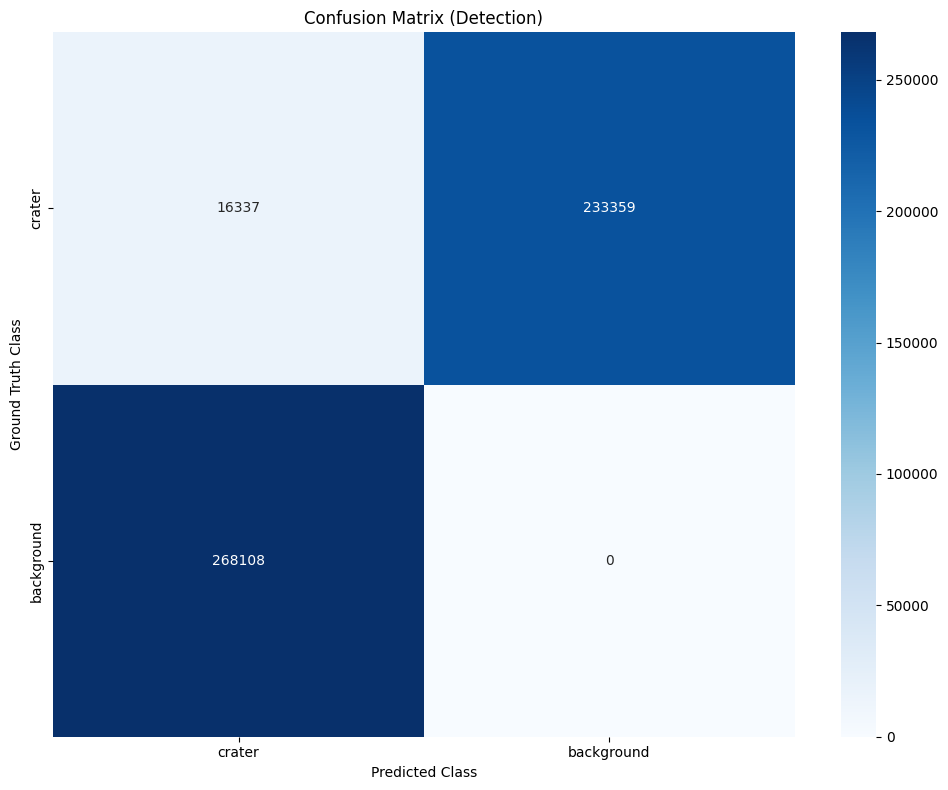

In [ ]:
labels = category_names + ['background']
cm = confusion_matrix(gt_classes_for_cm, pred_classes_for_cm, labels=list(range(len(labels))))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Ground Truth Class')
plt.title('Confusion Matrix (Detection)')
plt.tight_layout()
plt.show()